In [1]:
import json
from collections import Counter
import pickle
import numpy as np
import pandas as pd
import os
import sys
import argparse
from os.path import dirname, realpath

import math
import hashlib
import datetime
import datetime as datetime
sys.path.append("./src/")

import torch
from torch import nn, optim
from torch.nn import functional as F

from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator
sys.path.append(dirname(dirname(realpath(os.getcwd()))))

from scipy.optimize import minimize_scalar
from scipy.optimize import minimize
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt


In [2]:
src_path = "G:\\FillmoreCancerData\\markhe\\VTERisk" 
src_path2 = "G:\\FillmoreCancerData\\markhe\\VTERisk - Copy" 

def md5(key):
    return hashlib.md5(repr(key).encode()).hexdigest()
testDF = pd.read_csv(os.path.join(src_path2, 'Notebooks/Find/fixed_dx.csv'))
pat_ids = (testDF['patient_id'] ).astype(int)
testDF['pids'] = pat_ids.apply(md5)

In [3]:
def compute_calibration_curve(golds_for_eval,Probs_for_eval):
    prob_true, prob_pred = calibration_curve(golds_for_eval, Probs_for_eval, n_bins=20)
    return prob_true, prob_pred


In [4]:
import matplotlib.pyplot as plt

def plotter (p_i, y_i):
    plt.figure(figsize=(4, 4))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))
    ax1.plot(p_i, y_i, 's-')
    ax1.plot([0, 1], [0, 1], linestyle='--', 
             color='grey', label='random guess (AUROC: 0.500)')
    ax2.hist(p_i, bins=10, range=(0, 1))
    ax1.set_xlim([-0.01, 1.01])
    ax1.set_ylim([-0.01, 1.01])
    ax1.set_xlabel('Predicted value')
    ax1.set_ylabel('Fraction of positive')
    ax1.set_title("Calibration plot")
    ax2.set_xlabel('Prediction probability')
    ax2.set_ylabel('Count')
    plt.tight_layout()
    

In [5]:
def get_4Ms(M):
    M1 = M.drop_duplicates(['patient_id'])
    m0 = M.duplicated(['patient_id'])
    M234 = M[m0]
    M2 = M234.drop_duplicates(['patient_id'])

    m00 = M234.duplicated(['patient_id'])
    M34 = M234[m00]
    M3 = M34.drop_duplicates(['patient_id'])

    m000 = M34.duplicated(['patient_id'])
    M4 = M34[m000]
    return M1, M2, M3, M4

In [6]:
tdf = pd.DataFrame({'patient_id': (testDF['patient_id'] ),    
                    'pids': (testDF['pids'] ),    
                  'dob': (testDF['dob'] ),  
                  'outcome_date': (testDF['outcome_date'] ), 
                  'obs_time_end': (testDF['obs_time_end'] ),  
                  'index_date': (testDF['index_date'] ),  
                  'diag_date': (testDF['diag_date'] ),  
                  'outcome': (testDF['outcome'])    })

In [7]:
def logit (p): return np.log(  p / (1 - p) )
def expit (p): return   np.exp(p)/(1 + np.exp(p))

In [8]:
devpath = os.path.join(src_path ,'logs_transformer_vte/L/12_12/', "68e9a10a80da6c966c226a57b3ccf0fb.results.dev_preds")

with open(devpath, 'rb') as f:
    R = pickle.load(f)
    p = np.array(R['probs'])

Df = pd.DataFrame.from_dict(R)
Df['probs'] = Df['probs'].astype(float)
Df['exams'] = Df['exams'].astype(int)
M = pd.merge(tdf, Df)
M1, M2, M3, M4 = get_4Ms(M)

In [9]:
testpath = os.path.join(src_path ,'logs_transformer_vte/L/12_12/', "68e9a10a80da6c966c226a57b3ccf0fb.results.test_preds")
with open(testpath, 'rb') as f:
    R_t = pickle.load(f)

Df_test = pd.DataFrame.from_dict(R_t)
Df_test['probs'] = Df_test['probs'].astype(float)
M_test = pd.merge(tdf, Df_test)
M_test1, M_test2, M_test3, M_test4 = get_4Ms(M_test)

In [10]:
mp0 = np.array(M['probs'])
mp1 = np.array(M1['probs'])
mp2 = np.array(M2['probs'])
mp3 = np.array(M3['probs'])
mp4 = np.array(M4['probs'])

gold0 =   np.array(M['golds'],dtype = int)
gold1 =   np.array(M1['golds'],dtype = int)
gold2 =   np.array(M2['golds'],dtype = int)
gold3 =   np.array(M3['golds'],dtype = int)
gold4 =   np.array(M4['golds'],dtype = int)

tp= np.array(M_test['probs'])
tp1 = np.array(M_test1['probs'])
tp2 = np.array(M_test2['probs'])
tp3 = np.array(M_test3['probs'])
tp4 = np.array(M_test4['probs'])

tgold1 =   np.array(M_test1['golds'],dtype = int)
tgold2 =   np.array(M_test2['golds'],dtype = int)
tgold3 =   np.array(M_test3['golds'],dtype = int)
tgold4 =   np.array(M_test4['golds'],dtype = int)
tgold0 =   np.array(M_test['golds'],dtype = int)

In [11]:
global_temp = np.mean( logit(mp0))

(array([ 983., 3825., 6668., 8451., 9130., 9181., 8337., 5198., 2194.,
         313.]),
 array([-4.16897398, -3.76822041, -3.36746684, -2.96671327, -2.56595971,
        -2.16520614, -1.76445257, -1.363699  , -0.96294543, -0.56219186,
        -0.1614383 ]),
 <BarContainer object of 10 artists>)

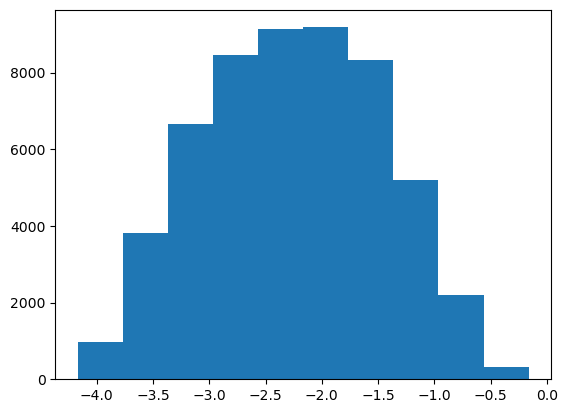

In [12]:
plt.hist(logit(mp0))

In [13]:
def temp_scaling_g (logits, y, global_temp):
    def temperature_obj(t):
        temp_logits =   logits /  t  - global_temp
        probs = expit(temp_logits)
        return log_loss(y, probs)    
    res = minimize_scalar(temperature_obj, bounds = (0,1))
    return res.x

In [26]:
wt00 = np.where(gold0 == 1, 1/np.mean(gold0), 1)
wts1 = np.where(gold1 == 1, 1/(np.mean(gold1)* .064), 1)
wts2 = np.where(gold2 == 1, 1/(np.mean(gold2)* .064), 1)
wts3 = np.where(gold3 == 1, 1/(np.mean(gold3)*.064 ), 1)
wts4 = np.where(gold4 == 1, 1/(np.mean(gold4)*.064), 1)

In [17]:
glob = np.mean(logit(mp0))

In [35]:
 def weighted_temp_scaling_g (logits, y, glob, wts):
    def temperature_obj(t):
        temp_logits =   logits /  t  - glob
        probs = expit(temp_logits)
        return log_loss(y, probs, sample_weight=wts)    
    res = minimize_scalar(temperature_obj, bounds = (0,1000000))
    return res.x

In [36]:
alpha_1  = weighted_temp_scaling_g(  logit(mp1), gold1, 0, wts1)
alpha_2  = weighted_temp_scaling_g(  logit(mp2), gold2, 0, wts2)
alpha_3  = weighted_temp_scaling_g(  logit(mp3), gold3, 0,  wts3)
alpha_4  = weighted_temp_scaling_g(  logit(mp4), gold4, 0,  wts4)

In [37]:
[alpha_1,alpha_2,alpha_3, alpha_4]

[999999.9757672098, 999999.9757671971, 999999.9757671854, 999999.9757671806]

In [22]:
def temp_pred_g  (alpha,  test_logit, global_temp):    
    logi =  test_logit/ alpha  - global_temp        
    proba = expit ( logi   ) #*tt.x[5]    
    return proba

In [122]:
def temp_pred  (alpha,  test_logit, global_temp):    
    logi =  test_logit/ alpha  - global_temp        
    proba = expit ( logi   ) #*tt.x[5]    
    return proba

In [23]:
cal_1 = temp_pred_g (alpha_1, logit(tp1), glob)
cal_2 = temp_pred_g (alpha_2, logit(tp2), glob)
cal_3 = temp_pred_g (alpha_3, logit(tp3), glob)
cal_4 = temp_pred_g (alpha_4, logit(tp4), glob)

In [24]:
y1, p1 = compute_calibration_curve(M_test1['golds'], cal_1 )
y2, p2 = compute_calibration_curve(M_test2['golds'], cal_2 )
y3, p3 = compute_calibration_curve(M_test3['golds'], cal_3 )
y4, p4 = compute_calibration_curve(M_test4['golds'], cal_4 )


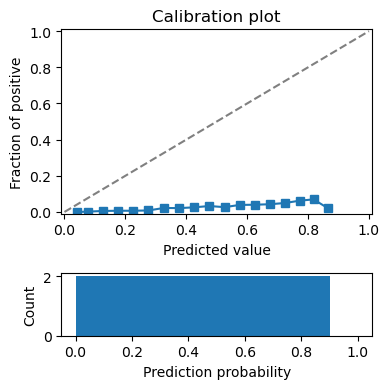

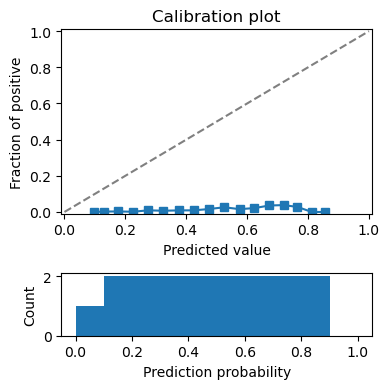

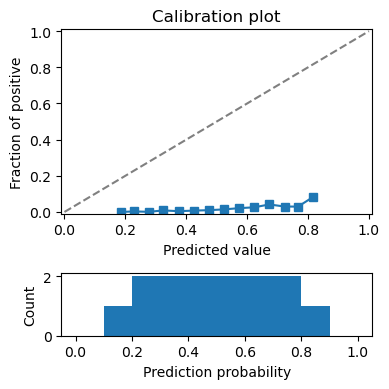

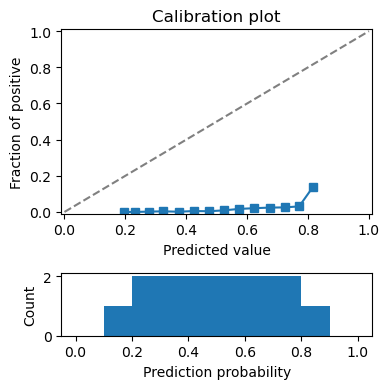

In [25]:
plotter(p1, y1)
plotter(p2, y2)
plotter(p3, y3)
plotter(p4, y4)


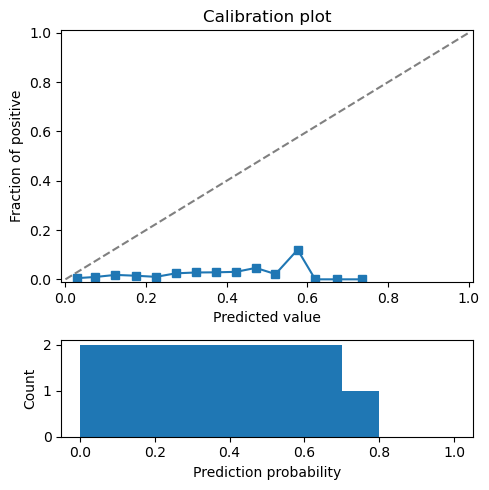

In [33]:
plotter(p2, y2)

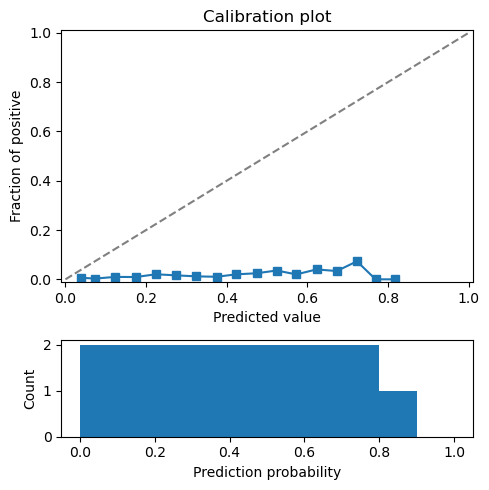

In [106]:
plotter(p2, y2)

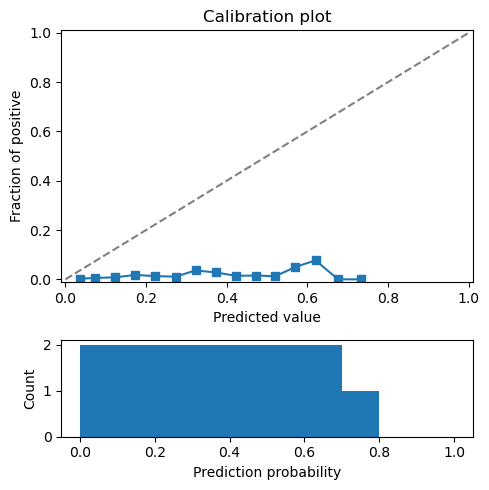

In [107]:
plotter(p3, y3)

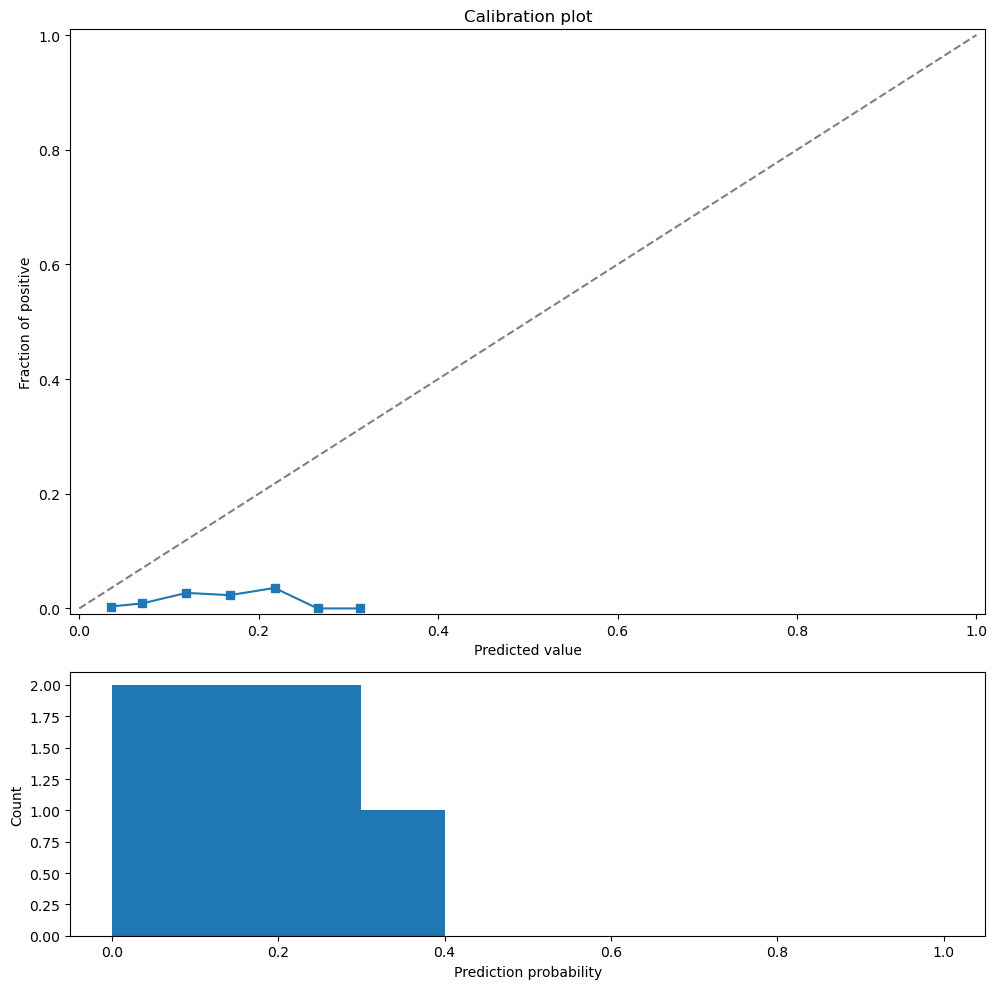

In [273]:
plotter(p4, y4)

(array([2451., 2792., 2698., 2569., 2145., 1737., 1021.,  459.,  146.,
          11.]),
 array([0.01589061, 0.06250444, 0.10911827, 0.1557321 , 0.20234593,
        0.24895976, 0.29557359, 0.34218742, 0.38880124, 0.43541507,
        0.4820289 ]),
 <BarContainer object of 10 artists>)

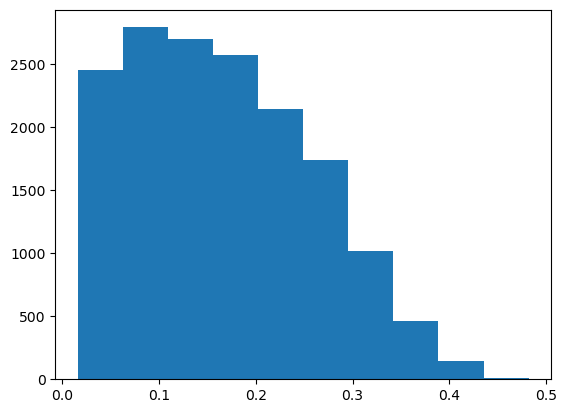

In [53]:
plt.hist( M1['probs'].to_numpy())

In [ ]:
sklearn.metrics.roc_auc_score(m1['outcome'],  m1['p6'], average = 'samples')


0.5600783435183764

In [ ]:
( confusion_matrix (m1['outcome'],  m1['p6']>.5) )

array([[72681,     5],
       [ 4301,     0]], dtype=int64)

In [ ]:
# how many people had event within 6 months of index date

In [27]:
m1.to_csv('output/XCoh_Sen.csv') 

In [34]:
#m1.to_excel('output/dxMD_Sensitivity90.xlsx') 

In [39]:
y1 = np.array(M1['golds'],dtype = int)
x1 = M1['probs'].to_numpy()
platt.fit(x1, y1)
cal_1 = platt.predict(M_test1['probs'])